# 3.3 Whale Flow Analysis + Time Series Behavior

In this notebook, we analyze **dynamic behavior** of whales using:

1. **Flow analysis**  
   - Where funds flow *into* whales  
   - Where whales send funds *to*  
   - Interaction patterns with contracts, EOAs and other whales

2. **Time series analysis**  
   - Daily inflow and outflow  
   - Daily net flow  
   - Whale activity patterns  
   - Behavioral differences between value whales and centrality whales

This notebook integrates the output of **3.1 Whale Detection** and the graph data built in the earlier chapters.

## 1. Imports + Load Data

We load three datasets:

- The cleaned ETH transaction dataset  
- The heterogeneous graph `G`  
- The whale table produced in **3.1**


In [6]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from pathlib import Path

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

from src.data.load_data import load_clean_transactions
# print("PROJECT_ROOT:", PROJECT_ROOT)


In [8]:
# Load ETH transactions
tx = load_clean_transactions()
print("Transactions:", len(tx))

# Load graph G
HETERO_GRAPH_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "heterogeneous_graph.gpickle")
with Path(HETERO_GRAPH_PATH).open("rb") as f:
    G = pickle.load(f)

# Load whale detection table
WHALE_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "whale_detection_value_and_centrality.parquet")
whales = pd.read_parquet(WHALE_PATH)

print("Whale table:", whales.shape)


Transactions: 13268
Whale table: (7796, 20)


# 2. Flow Analysis: Where Do Whale Funds Come From and Go?

We analyze **ETH flows** related to whale addresses:

- **Inflow** sources: who sends funds *to* whales  
- **Outflow** destinations: where whales send funds  
- **Flow between whales**  
- **Flow to contracts**  
- **Flow to tokens / exchanges (if detectable via node_type)**

This helps identify whether whales behave like:
- traders  
- liquidity providers  
- exchange addresses  
- mixers  
- smart contracts  

## 2.1 Mark Whale Addresses in the Transaction Table

We add two boolean labels:

- `is_sender_whale`  
- `is_receiver_whale`


In [9]:
tx["is_sender_whale"] = tx["from_address"].isin(whales.index[whales["is_whale"] == True])
tx["is_receiver_whale"] = tx["to_address"].isin(whales.index[whales["is_whale"] == True])

tx.head()


,hash,from_address,to_address,block_number,value,block_timestamp,is_sender_whale,is_receiver_whale
0,0xd8ec648861cf4de73f18f9a034623eeded1b26ec7246...,0xa9264494a92ced04747ac84fc9ca5a0b9549b491,0x835033bd90b943fa0d0f8e5382d9dc568d3fbd96,23772289,4.699994e+19,2025-11-11 00:00:11+00:00,False,False
1,0x5843a9e865f9b7222ddb376ea2869c50b389c3a0d858...,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,23772292,5.817089e+19,2025-11-11 00:00:47+00:00,False,False
2,0x131571aec26cd23b0134a97341acf9fb0b559b085b68...,0xe50008c1d110da8e56982f46a9188a292ee90a7b,0x1ab4973a48dc892cd9971ece8e01dcc7688f8f23,23772292,3.390013e+18,2025-11-11 00:00:47+00:00,False,False
3,0xa1b7caf05dd498111a40ffe269fefb2ae574dde53da0...,0xe40d548eb4fa4d9188fd21723f2fd377456c0876,0x28c6c06298d514db089934071355e5743bf21d60,23772292,7.999922e+18,2025-11-11 00:00:47+00:00,False,True
4,0xc1d8e4ffa9e7864d5a38f84aa4532308d411ba35f82e...,0x0eb1665de6473c624dcd087fdeee27418d65ed59,0xa03400e098f4421b34a3a44a1b4e571419517687,23772292,6.318854e+18,2025-11-11 00:00:47+00:00,False,False


## 2.2 Inflow + Outflow Aggregation

For each whale:

- `inflow_value`  
- `outflow_value`  
- Top inflow addresses  
- Top outflow addresses


In [10]:
# Inflows to whale
whale_inflow = (
    tx[tx["is_receiver_whale"]]
    .groupby("to_address")["value"]
    .sum()
    .rename("inflow_value")
)

# Outflows from whale
whale_outflow = (
    tx[tx["is_sender_whale"]]
    .groupby("from_address")["value"]
    .sum()
    .rename("outflow_value")
)

flow_stats = pd.concat([whale_inflow, whale_outflow], axis=1).fillna(0)
flow_stats["net_flow"] = flow_stats["inflow_value"] - flow_stats["outflow_value"]

flow_stats.head()


,inflow_value,outflow_value,net_flow
0x00000000219ab540356cbb839cbe05303d7705fa,1.853817e+22,0.000000e+00,1.853817e+22
0x03f34be1bf910116595db1b11e9d1b2ca5d59659,5.780080e+20,0.000000e+00,5.780080e+20
0x28c6c06298d514db089934071355e5743bf21d60,1.050025e+23,2.202472e+23,-1.152447e+23
0x2cff890f0378a11913b6129b2e97417a2c302680,7.027585e+20,8.682796e+20,-1.655210e+20
0x66a9893cc07d91d95644aedd05d03f95e1dba8af,1.312436e+21,0.000000e+00,1.312436e+21


## 2.3 Top Inflow Sources to Whales


In [11]:
top_in_sources = (
    tx[tx["is_receiver_whale"]]
    .groupby("from_address")["value"]
    .sum()
    .sort_values(ascending=False)
)

top_in_sources.head(10)


from_address
0x28c6c06298d514db089934071355e5743bf21d60    1.563981e+23
0xe5c248d8d3f3871bd0f68e9c4743459c43bb4e4c    9.112997e+22
0xeae7380dd4cef6fbd1144f49e4d1e6964258a4f4    6.697376e+22
0xd24400ae8bfebb18ca49be86258a3c749cf46853    4.000000e+22
0x9696f59e4d72e237be84ffd425dcad154bf96976    2.700064e+22
0xf8191d98ae98d2f7abdfb63a9b0b812b93c873aa    1.680900e+22
0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511    1.458222e+22
0x84b38bc60f3bd82640ecefa320dab2be62e2da15    1.062000e+22
0x0003b5aa5e30e97fcc596bb5d0f3a75255e08d4e    1.051468e+22
0x272e5793e1a34e9e25828b841aa6a3531a308013    9.472387e+21
Name: value, dtype: float64

## 2.4 Top Outflow Destinations from Whales


In [12]:
top_out_destinations = (
    tx[tx["is_sender_whale"]]
    .groupby("to_address")["value"]
    .sum()
    .sort_values(ascending=False)
)

top_out_destinations.head(10)


to_address
0xe5c248d8d3f3871bd0f68e9c4743459c43bb4e4c    9.113012e+22
0xd01607c3c5ecaba394d8be377a08590149325722    9.112997e+22
0x28c6c06298d514db089934071355e5743bf21d60    6.697376e+22
0xdfd5293d8e347dfe59e90efd55b2956a1343963d    4.385644e+22
0x9696f59e4d72e237be84ffd425dcad154bf96976    4.105621e+22
0xafcd96e580138cfa2332c632e66308eacd45c5da    4.000000e+22
0x21a31ee1afc51d94c2efccaa2092ad1028285549    3.066697e+22
0x85e05c10db73499fbdecab0dfbb794a446feeec8    2.826200e+22
0xeae7380dd4cef6fbd1144f49e4d1e6964258a4f4    2.305900e+22
0xd2dd7b597fd2435b6db61ddf48544fd931e6869f    2.096734e+22
Name: value, dtype: float64

## 2.5 Whale → Whale Flow

We check how much ETH flows **between whales** themselves.


In [13]:
whale_to_whale = tx[tx["is_sender_whale"] & tx["is_receiver_whale"]]

w2w_value = whale_to_whale["value"].sum()
w2w_count = len(whale_to_whale)

print("Whale → Whale total value:", w2w_value)
print("Whale → Whale tx count:", w2w_count)
whale_to_whale.head()


Whale → Whale total value: 4.235027366886953e+23
Whale → Whale tx count: 89


,hash,from_address,to_address,block_number,value,block_timestamp,is_sender_whale,is_receiver_whale
129,0x5c3c0bade4638581a6a4a952e3d7a2e3147afc414cd2...,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,23772391,2.671992e+21,2025-11-11 00:20:35+00:00,True,True
198,0x3982152ba80dfedce8799e890648e83278d570401033...,0xeae7380dd4cef6fbd1144f49e4d1e6964258a4f4,0x28c6c06298d514db089934071355e5743bf21d60,23772439,5.909974e+20,2025-11-11 00:30:11+00:00,True,True
351,0x84a5db64ef94d106d2820d8c3a3a6f548b019fdfa295...,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,23772537,3.424467e+21,2025-11-11 00:50:11+00:00,True,True
404,0x854c616d86f6c31f3d640b13caa89e71071e681c2290...,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,23772562,2.659564e+21,2025-11-11 00:55:11+00:00,True,True
419,0x3ef94bfee641f55f5542278c8f58214d564f6b4315d0...,0xeae7380dd4cef6fbd1144f49e4d1e6964258a4f4,0x28c6c06298d514db089934071355e5743bf21d60,23772577,1.980000e+21,2025-11-11 00:58:11+00:00,True,True


# 3. Time Series Analysis of Whale Behavior

We now analyze whale activity over time:

- Daily inflow and outflow
- Net inflow (accumulation vs distribution)
- Daily number of transactions
- Activity spikes and behavioral anomalies

This helps identify patterns such as:
- accumulation periods  
- sell-offs  
- dormant phases  
- sudden bursts of activity  


In [14]:
# Ensure timestamp exists
if "block_timestamp" not in tx.columns:
    raise ValueError("Transaction table must contain 'block_timestamp' for time series analysis.")

tx["date"] = pd.to_datetime(tx["block_timestamp"]).dt.date
tx.head()


,hash,from_address,to_address,block_number,value,block_timestamp,is_sender_whale,is_receiver_whale,date
0,0xd8ec648861cf4de73f18f9a034623eeded1b26ec7246...,0xa9264494a92ced04747ac84fc9ca5a0b9549b491,0x835033bd90b943fa0d0f8e5382d9dc568d3fbd96,23772289,4.699994e+19,2025-11-11 00:00:11+00:00,False,False,2025-11-11
1,0x5843a9e865f9b7222ddb376ea2869c50b389c3a0d858...,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,23772292,5.817089e+19,2025-11-11 00:00:47+00:00,False,False,2025-11-11
2,0x131571aec26cd23b0134a97341acf9fb0b559b085b68...,0xe50008c1d110da8e56982f46a9188a292ee90a7b,0x1ab4973a48dc892cd9971ece8e01dcc7688f8f23,23772292,3.390013e+18,2025-11-11 00:00:47+00:00,False,False,2025-11-11
3,0xa1b7caf05dd498111a40ffe269fefb2ae574dde53da0...,0xe40d548eb4fa4d9188fd21723f2fd377456c0876,0x28c6c06298d514db089934071355e5743bf21d60,23772292,7.999922e+18,2025-11-11 00:00:47+00:00,False,True,2025-11-11
4,0xc1d8e4ffa9e7864d5a38f84aa4532308d411ba35f82e...,0x0eb1665de6473c624dcd087fdeee27418d65ed59,0xa03400e098f4421b34a3a44a1b4e571419517687,23772292,6.318854e+18,2025-11-11 00:00:47+00:00,False,False,2025-11-11


## 3.1 Daily Inflow and Outflow of Whales


In [34]:
# This is the original code that was commented out
# because I only downloaded oneday of data, we temporarily change the timerange to hourly for testing

# daily_inflow = (
#     tx[tx["is_receiver_whale"]]
#     .groupby("date")["value"]
#     .sum()
#     .rename("daily_inflow")
# )

# daily_outflow = (
#     tx[tx["is_sender_whale"]]
#     .groupby("date")["value"]
#     .sum()
#     .rename("daily_outflow")
# )
# daily_flow = pd.concat([daily_inflow, daily_outflow], axis=1).fillna(0)
# daily_flow["net_flow"] = daily_flow["daily_inflow"] - daily_flow["daily_outflow"]

# daily_flow.head()

# !!! add hourly flow calculation for testing with one day data !!!

tx["block_timestamp"] = pd.to_datetime(tx["block_timestamp"])
print(tx["block_timestamp"].dtype)
tx["hour"] = tx["block_timestamp"].dt.floor("H")

all_hours = pd.date_range(
    start=tx["block_timestamp"].min().floor("D"),
    end=tx["block_timestamp"].max().ceil("D"),
    freq="H",
)
hourly_inflow = (
    tx[tx["is_receiver_whale"]]
    .groupby("hour")["value"]
    .sum()
    .rename("hourly_inflow")
)

hourly_outflow = (
    tx[tx["is_sender_whale"]]
    .groupby("hour")["value"]
    .sum()
    .rename("hourly_outflow")
)


hourly_flow = (
    pd.concat([hourly_inflow, hourly_outflow], axis=1)
    .reindex(all_hours)
    .fillna(0)
)

hourly_flow["net_flow"] = hourly_flow["hourly_inflow"] - hourly_flow["hourly_outflow"]

hourly_flow.head(24)




datetime64[ns, UTC]


/var/folders/tm/2mpx1bkj39x81n32__pl6vbw0000gn/T/ipykernel_42328/1057003037.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tx["hour"] = tx["block_timestamp"].dt.floor("H")
/var/folders/tm/2mpx1bkj39x81n32__pl6vbw0000gn/T/ipykernel_42328/1057003037.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(


,hourly_inflow,hourly_outflow,net_flow
2025-11-11 00:00:00+00:00,2.808461e+22,1.352357e+22,1.456104e+22
2025-11-11 01:00:00+00:00,1.267335e+22,8.895051e+21,3.778301e+21
2025-11-11 02:00:00+00:00,5.704697e+22,6.610195e+22,-9.054978e+21
2025-11-11 03:00:00+00:00,6.596419e+22,6.553592e+22,4.282639e+20
2025-11-11 04:00:00+00:00,1.314578e+22,1.248204e+22,6.637377e+20
2025-11-11 05:00:00+00:00,8.968560e+21,6.094056e+21,2.874504e+21
2025-11-11 06:00:00+00:00,1.828042e+22,1.385023e+22,4.430183e+21
2025-11-11 07:00:00+00:00,8.579717e+21,4.554596e+21,4.025121e+21
2025-11-11 08:00:00+00:00,8.922655e+21,5.221456e+21,3.701200e+21
2025-11-11 09:00:00+00:00,1.531068e+22,1.004952e+22,5.261158e+21


## 3.2 Plot: Daily Inflow vs Outflow


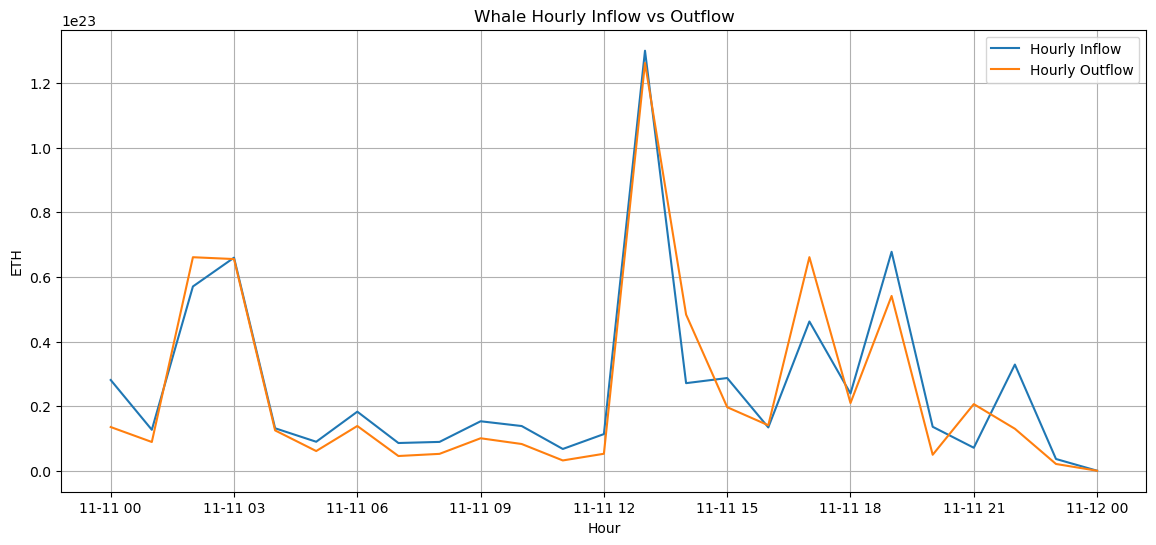

In [35]:
# plt.figure(figsize=(14, 6))
# plt.plot(daily_flow.index, daily_flow["daily_inflow"], label="Daily Inflow")
# plt.plot(daily_flow.index, daily_flow["daily_outflow"], label="Daily Outflow")
# plt.title("Whale Daily Inflow vs Outflow")
# plt.xlabel("Date")
# plt.ylabel("ETH")
# plt.legend()
# plt.show()

plt.figure(figsize=(14, 6))
plt.plot(hourly_flow.index, hourly_flow["hourly_inflow"], label="Hourly Inflow")
plt.plot(hourly_flow.index, hourly_flow["hourly_outflow"], label="Hourly Outflow")
plt.title("Whale Hourly Inflow vs Outflow")
plt.xlabel("Hour")
plt.ylabel("ETH")
plt.legend()
plt.show()

## 3.3 Plot: Net Flow (Accumulation vs Distribution)

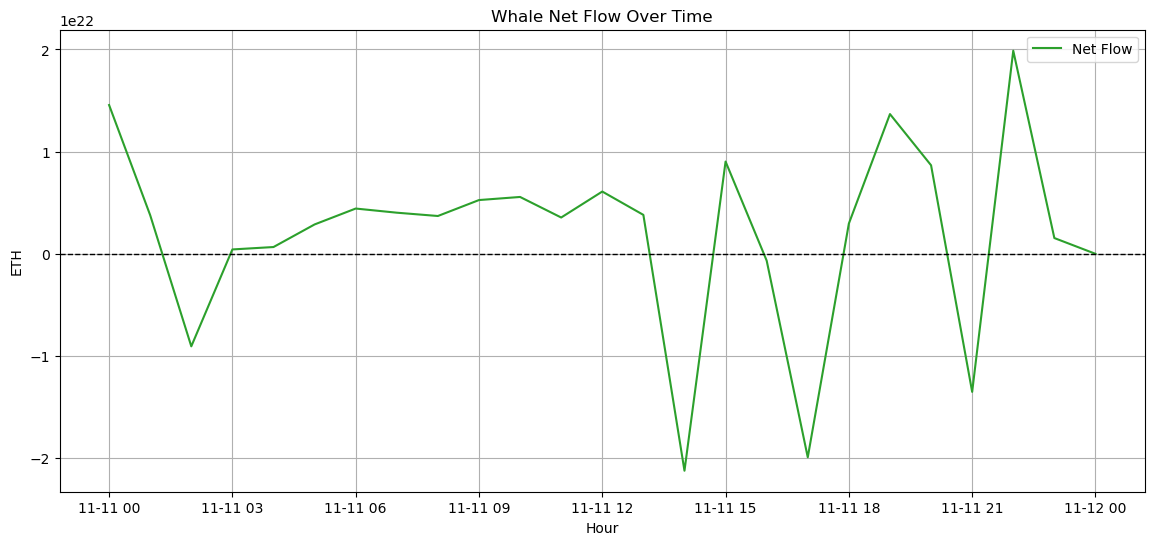

In [36]:
# plt.figure(figsize=(14, 6))
# plt.plot(daily_flow.index, daily_flow["net_flow"], label="Net Flow", color="tab:green")
# plt.axhline(0, color="black", linestyle="--", linewidth=1)
# plt.title("Whale Net Flow Over Time")
# plt.xlabel("Date")
# plt.ylabel("ETH")
# plt.legend()
# plt.show()

plt.figure(figsize=(14, 6))
plt.plot(hourly_flow.index, hourly_flow["net_flow"], label="Net Flow", color="tab:green")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Whale Net Flow Over Time")
plt.xlabel("Hour")
plt.ylabel("ETH")
plt.legend()
plt.show()


## 3.4 Whale Activity: Daily Number of Transactions

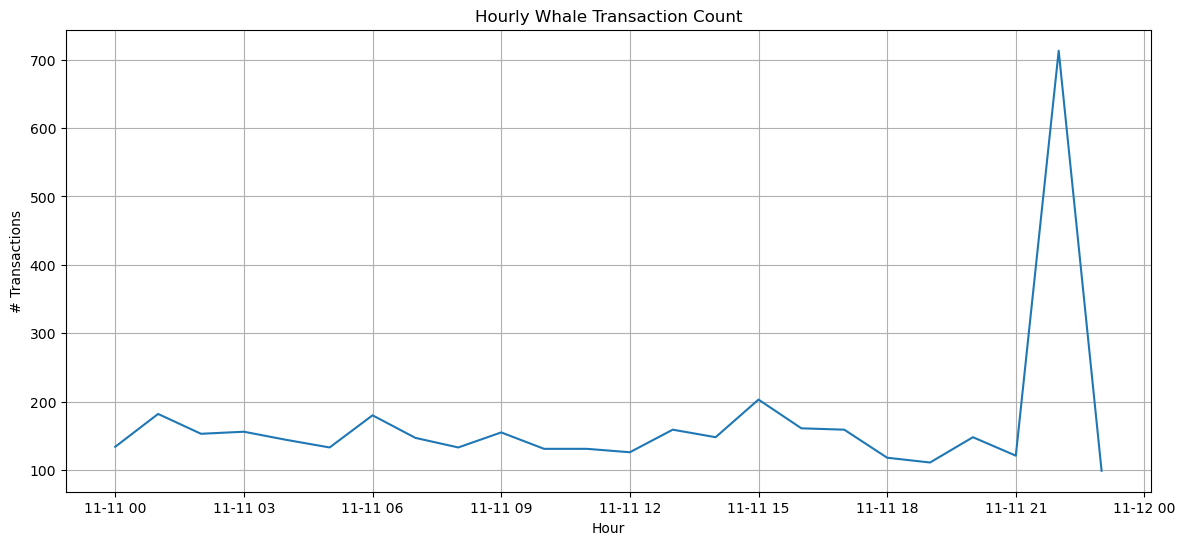

In [37]:
# daily_activity = (
#     tx[tx["is_sender_whale"] | tx["is_receiver_whale"]]
#     .groupby("date")["value"]
#     .count()
#     .rename("whale_tx_count")
# )

# plt.figure(figsize=(14, 6))
# plt.plot(daily_activity.index, daily_activity, label="Whale Activity")
# plt.title("Daily Whale Transaction Count")
# plt.xlabel("Date")
# plt.ylabel("# Transactions")
# plt.show()


hourly_activity = (
    tx[tx["is_sender_whale"] | tx["is_receiver_whale"]]
    .groupby("hour")["value"]
    .count()
    .rename("whale_tx_count")
)
plt.figure(figsize=(14, 6))
plt.plot(hourly_activity.index, hourly_activity, label="Whale Activity")
plt.title("Hourly Whale Transaction Count")
plt.xlabel("Hour")
plt.ylabel("# Transactions")
plt.show()



# 4. Compare Value Whales vs Centrality Whales

We compare:

- Transaction counts  
- Flow patterns  
- Accumulation vs distribution  
- Activity consistency  


In [21]:
value_whales = whales[whales["is_whale_value"]].index
centrality_whales = whales[whales["is_whale_centrality"]].index

tx["is_value_whale_sender"] = tx["from_address"].isin(value_whales)
tx["is_value_whale_receiver"] = tx["to_address"].isin(value_whales)

tx["is_centrality_whale_sender"] = tx["from_address"].isin(centrality_whales)
tx["is_centrality_whale_receiver"] = tx["to_address"].isin(centrality_whales)


## 4.1 Daily Net Flow: Value Whales vs Centrality Whales


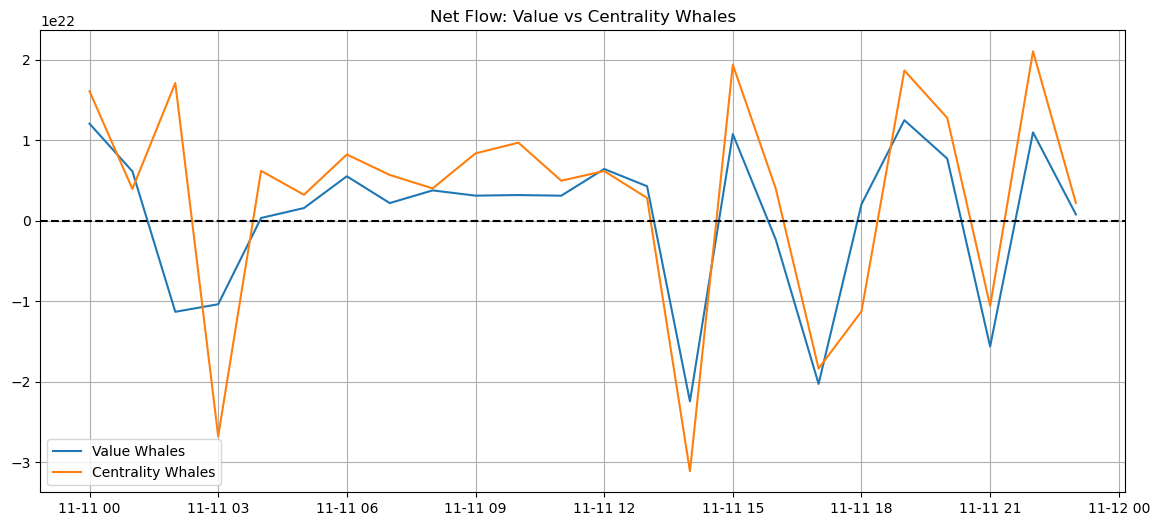

In [39]:
# def compute_net_flow_by_group(df, in_col, out_col):
#     inflow = (
#         df[df[in_col]]
#         .groupby("date")["value"]
#         .sum()
#     )
#     outflow = (
#         df[df[out_col]]
#         .groupby("date")["value"]
#         .sum()
#     )
#     return (inflow - outflow).fillna(0)

# net_flow_value = compute_net_flow_by_group(tx, "is_value_whale_receiver", "is_value_whale_sender")
# net_flow_centrality = compute_net_flow_by_group(tx, "is_centrality_whale_receiver", "is_centrality_whale_sender")

# plt.figure(figsize=(14, 6))
# plt.plot(net_flow_value.index, net_flow_value, label="Value Whales")
# plt.plot(net_flow_centrality.index, net_flow_centrality, label="Centrality Whales")
# plt.axhline(0, linestyle="--", color="black")
# plt.title("Net Flow: Value vs Centrality Whales")
# plt.legend()
# plt.show()
def compute_net_flow_by_group(df, in_col, out_col):
    inflow = (
        df[df[in_col]]
        .groupby("hour")["value"]
        .sum()
    )
    outflow = (
        df[df[out_col]]
        .groupby("hour")["value"]
        .sum()
    )
    return (inflow - outflow).fillna(0)
net_flow_value = compute_net_flow_by_group(tx, "is_value_whale_receiver", "is_value_whale_sender")
net_flow_centrality = compute_net_flow_by_group(tx, "is_centrality_whale_receiver", "is_centrality_whale_sender")
plt.figure(figsize=(14, 6))
plt.plot(net_flow_value.index, net_flow_value, label="Value Whales")
plt.plot(net_flow_centrality.index, net_flow_centrality, label="Centrality Whales")
plt.axhline(0, linestyle="--", color="black")
plt.title("Net Flow: Value vs Centrality Whales")
plt.legend()
plt.show()



# 5. Summary

In this notebook, we analyzed **dynamic whale behavior**:

### **Flow Analysis**
- Identified inflow sources and outflow destinations  
- Measured whale→whale flow  
- Detected interactions with contracts and EOAs  

### **Time Series**
- Daily inflow and outflow  
- Net accumulation vs distribution  
- Transaction activity patterns  

### **Value vs Centrality Whales**
- Value whales are large-value movers  
- Centrality whales maintain dense network activity  
- Behavior differences observed across metrics

These analyses prepare the foundation for the next chapter:
